# Quantization-Aware Training (QAT) for CIFAR-10 with ResNet20

Quantization-Aware Training (QAT) is a technique used to simulate the effects of quantization during the training process of a neural network. This helps the model to learn and adapt to the quantization effects, resulting in better performance when the model is actually quantized.

This notebook demonstrates the process of quantization-aware training (QAT) using a ResNet20 model trained on the CIFAR-10 dataset. The goal is to perform QAT and compare the weights and activations before and after quantization.


In [ ]:
!git clone https://github.com/yundogyeong/bootcamp.git
!mv bootcamp/*.py .

Cloning into 'bootcamp'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 6), reused 7 (delta 0), pack-reused 0
Receiving objects: 100% (21/21), 11.46 KiB | 3.82 MiB/s, done.
Resolving deltas: 100% (6/6), done.


## 1. Import Libraries

We start by importing the necessary libraries. This includes PyTorch, NumPy, Matplotlib, and other utility functions.

In [ ]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from torch.quantization import get_default_qat_qconfig, prepare_qat, QConfig
from torch.quantization.observer import MovingAverageMinMaxObserver, PerChannelMinMaxObserver, MinMaxObserver, _ObserverBase
from torch.quantization.fake_quantize import FakeQuantize

from utils import module_wrapper, accuracy, get_loader
from model import cifar10_resnet20

## Preparing for Quantization-Aware Training (QAT)


In [ ]:
model = cifar10_resnet20(pretrained=True)
model, fuse_list = module_wrapper(model)

# Load CIFAR-10 dataset
train_loader, test_loader = get_loader()

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 12.8MB/s]


100%|██████████| 170498071/170498071 [00:03<00:00, 56622309.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<strong>TODO:</strong> Create custom weight observer

In [ ]:
class CustomWeightObserver(_ObserverBase):
    def __init__(
            self,
            dtype=torch.quint8,
            qscheme=torch.per_tensor_affine,
            quant_min=None,
            quant_max=None,
            factory_kwargs=None,
            **kwargs) -> None:
        super().__init__(
            dtype=dtype,
            qscheme=qscheme,
            quant_min=quant_min,
            quant_max=quant_max,
            factory_kwargs=factory_kwargs,
            **kwargs)

        self.ch_axis = 0
        factory_kwargs = torch.nn.factory_kwargs(factory_kwargs)
        self.register_buffer("min_val", torch.tensor(float("inf"), **factory_kwargs))
        self.register_buffer("max_val", torch.tensor(float("-inf"), **factory_kwargs))

    def forward(self, x):
        if x.numel() == 0:
            return x

        x_detached = x.detach() # to avoid keeping autograd tape
        x_detached = x_detached.to(self.min_val.dtype)
        min_val, max_val = self.custom_min_max_calculator(x_detached)
        if min_val.shape != self.min_val.shape:
            self.min_val.resize_(min_val.shape)
        if max_val.shape != self.max_val.shape:
            self.max_val.resize_(max_val.shape)
        self.min_val.copy_(min_val)
        self.max_val.copy_(max_val)
        return x

    # TODO: Implement custom min-max calculator
    def custom_min_max_calculator(self, x):
          # THIS IS EXAMPLE CODE FOR PER_TENSOR MIN-MAX CALCULATOR
          if self.qscheme in [torch.per_tensor_affine, torch.per_tensor_symmetric]:
              min_val = torch.amin(x)
              max_val = torch.amax(x)
              total_min = torch.min(self.min_val, min_val)
              total_max = torch.max(self.max_val, max_val)
          # THIS IS EXAMPLE CODE FOR PER_CHANNEL MIN-MAX CALCULATOR
          elif self.qscheme in [torch.per_channel_affine, torch.per_channel_symmetric]:
              # we are assuming that the channel-wise axis is 0
              axis_list = [i for i in range(len(x.size())) if i != 0]
              min_val = torch.amin(x, dim=axis_list)
              max_val = torch.amax(x, dim=axis_list)
              total_min = torch.min(self.min_val, min_val)
              total_max = torch.max(self.max_val, max_val)
          return total_min, total_max

    @torch.jit.export
    def calculate_qparams(self):
        return self._calculate_qparams(self.min_val, self.max_val)

    @torch.jit.export
    def extra_repr(self):
        return "min_val={}, max_val={}".format(self.min_val, self.max_val)

    @torch.jit.export
    def reset_min_max_vals(self):
        self.min_val.copy_(torch.tensor(float("inf")))
        self.max_val.copy_(torch.tensor(float("-inf")))

<strong>TODO:</strong> Create custom activation observer

In [ ]:
class CustomActivationObserver(_ObserverBase):
    def __init__(
            self,
            dtype=torch.quint8,
            qscheme=torch.per_channel_symmetric,
            quant_min=None,
            quant_max=None,
            factory_kwargs=None,
            **kwargs) -> None:
        super().__init__(
            dtype=dtype,
            qscheme=qscheme,
            quant_min=quant_min,
            quant_max=quant_max,
            factory_kwargs=factory_kwargs,
            **kwargs)

        factory_kwargs = torch.nn.factory_kwargs(factory_kwargs)
        self.register_buffer("min_val", torch.tensor(float("inf"), **factory_kwargs))
        self.register_buffer("max_val", torch.tensor(float("-inf"), **factory_kwargs))

    def forward(self, x):
        if x.numel() == 0:
            return x

        x_detached = x.detach() # to avoid keeping autograd tape
        x_detached = x_detached.to(self.min_val.dtype)
        min_val, max_val = self.custom_min_max_calculator(x_detached)
        self.min_val.copy_(min_val)
        self.max_val.copy_(max_val)
        return x

    # TODO: Implement custom min-max calculator
    def custom_min_max_calculator(self, x):
        # THIS IS EXAMPLE CODE FOR PER_TENSOR MIN-MAX CALCULATOR
        # assert self.qscheme in [torch.per_tensor_affine]
        # min_val = torch.amin(x)
        # max_val = torch.amax(x)
        # total_min = torch.min(self.min_val, min_val)
        # total_max = torch.max(self.max_val, max_val)

        # THIS IS EXAMPLE CODE FOR MOVING_AVERAGE MIN-MAX CALCULATOR
        assert self.qscheme in [torch.per_tensor_affine]
        min_val = torch.amin(x)
        max_val = torch.amax(x)
        if self.min_val == float("inf") and self.max_val == float("-inf"):
            total_min, total_max = min_val, max_val
        else:
            total_min = 0.99 * self.min_val + 0.01 * min_val
            total_max = 0.99 * self.max_val + 0.01 * max_val
        return total_min, total_max

    @torch.jit.export
    def calculate_qparams(self):
        return self._calculate_qparams(self.min_val, self.max_val)

    @torch.jit.export
    def extra_repr(self):
        return "min_val={}, max_val={}".format(self.min_val, self.max_val)

    @torch.jit.export
    def reset_min_max_vals(self):
        self.min_val.copy_(torch.tensor(float("inf")))
        self.max_val.copy_(torch.tensor(float("-inf")))

We prepare the ResNet-20 model for Quantization-Aware Training (QAT) on the CIFAR-10 dataset. The steps are outlined as follows:

<strong>TODO:</strong> Initialize quantization configs...

In [ ]:
# Define quantization configuration
qconfig = QConfig(
    activation=FakeQuantize.with_args(observer=CustomActivationObserver, quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine),
    weight=FakeQuantize.with_args(observer=CustomWeightObserver, quant_min=-127, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric)
)
model.qconfig = qconfig

# model = torch.ao.quantization.fuse_modules_qat(model, fuse_list)


# Prepare model for quantization-aware training
model = prepare_qat(model).cuda()
print(model)

## Training and Converting the Model for Quantization-Aware Training (QAT)

In this cell, we train the ResNet-20 model on the CIFAR-10 dataset for one epoch and then convert it to an INT8 model using the learned quantization configurations. By following these steps, the model is trained and then converted to an INT8 representation.

In [ ]:
# Define optimizer and criterion
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Enable training mode
model.train()

# # Train the model for one epoch
for epoch in range(1):
    with tqdm(train_loader, unit="batch", ncols=95) as t:
        for i, (images, targets) in enumerate(t):
            images, targets = images.cuda(), targets.cuda()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, targets)

            # Compute accuracy
            acc1, acc5 = accuracy(outputs.data, targets.data, topk=(1, 5))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            t.set_postfix(loss=loss.item(), acc1=acc1.item(), acc5=acc5.item())

100%|███████████████████| 391/391 [00:51<00:00,  7.62batch/s, acc1=98.8, acc5=100, loss=0.0134]


In [ ]:
# Convert FP model to INT8 with the learned quantization configs
model.cpu().eval()
torch.quantization.convert(model, inplace=True)
torch.save(model.state_dict(), 'model_state_dict.pth')

In [ ]:
# model load
model.load_state_dict(torch.load('model_state_dict.pth'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:403: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


QuantWrapper(
  (quant): Quantize(scale=tensor([0.0203]), zero_point=tensor([120]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (module): CifarResNet(
    (conv1): QuantizedConv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.05296965315937996, zero_point=128, padding=(1, 1), bias=False)
    (bn1): QuantizedBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.014766533859074116, zero_point=161, padding=(1, 1), bias=False)
        (bn1): QuantizedBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): QuantizedConv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=0.012677110731601715, zero_point=132, padding=(1, 1), bias=False)
        (bn2): QuantizedBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_run

## Function: `get_distributions`

This function extracts the weight and activation distributions from a given model. It is particularly useful for analyzing models before and after quantization.


In [ ]:
def get_distributions(model, input_data):
  weights = []
  activations = []
  hooks = []
  def hook_fn_qat_forward(module, input, output):
    if isinstance(module, (torch.nn.quantized.Conv2d)):
        weights.append(module.weight().dequantize().detach().cpu().numpy())
        activations.append(output.dequantize().detach().cpu().numpy())
    elif isinstance(module, (nn.Conv2d)):
          weights.append(module.weight.detach().cpu().numpy())
          activations.append(output.detach().cpu().numpy())

  for name, layer in model.named_modules():
      if isinstance(layer, (torch.nn.quantized.Conv2d)):
          hooks.append(layer.register_forward_hook(hook_fn_qat_forward))
      elif isinstance(layer, (torch.nn.Conv2d)):
          hooks.append(layer.register_forward_hook(hook_fn_qat_forward))

  with torch.no_grad():
      output = model(input_data)

  for hook in hooks:
      hook.remove()

  return weights, activations

In [ ]:
def plot_weight_distributions(layer_names, org_weights, qat_weights, save_path='weight_distributions.png'):
    fig, axes = plt.subplots(len(layer_names), 1, figsize=(10, 5 * len(layer_names)))

    for i, (name, org_w, qat_w) in enumerate(zip(layer_names, org_weights, qat_weights)):
        ax = axes[i]
        ax.hist(org_w.flatten(), bins=50, alpha=0.5, label='Original', color='blue')
        ax.hist(qat_w.flatten(), bins=50, alpha=0.5, label='QAT', color='red')
        ax.set_title(f'Layer {i+1} ({name}) Weight Distribution')
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    plt.close()

In [ ]:
def plot_activation_distributions(layer_names, org_activations, qat_activations):
    fig, axes = plt.subplots(len(layer_names), 2, figsize=(15, 5 * len(layer_names)))

    for i, (name, org_act, qat_act) in enumerate(zip(layer_names, org_activations, qat_activations)):
        # Calculate the common y-axis limit
        all_acts = np.concatenate([org_act.flatten(), qat_act.flatten()])
        y_min, y_max = np.min(all_acts), np.max(all_acts)

        axes[i, 0].boxplot(org_act.flatten())
        axes[i, 0].set_ylim([y_min, y_max])
        axes[i, 0].set_title(f'Layer {i+1} ({name}) Original Activation Distribution')
        axes[i, 0].set_xlabel('Original')
        axes[i, 0].set_ylabel('Activation Value')

        axes[i, 1].boxplot(qat_act.flatten())
        axes[i, 1].set_ylim([y_min, y_max])
        axes[i, 1].set_title(f'Layer {i+1} ({name}) QAT Activation Distribution')
        axes[i, 1].set_xlabel('QAT')
        axes[i, 1].set_ylabel('Activation Value')

    plt.tight_layout()
    plt.show()
    plt.savefig('activation_distributions.png')
    plt.close()

In [ ]:
def plot_activation_histogram(layer_names, org_activations, qat_activations):
    fig, axes = plt.subplots(len(layer_names), 1, figsize=(10, 5 * len(layer_names)))

    for i, (name, org_act, qat_act) in enumerate(zip(layer_names, org_activations, qat_activations)):
        ax = axes[i]
        ax.hist(org_act.flatten(), bins=50, alpha=0.5, label='Original', color='blue')
        ax.hist(qat_act.flatten(), bins=50, alpha=0.5, label='QAT', color='red')
        ax.set_title(f'Layer {i+1} ({name}) Activation Distribution')
        ax.set_xlabel('Activation Value')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig('activation_distributions_histogram.png')
    plt.close()

In [ ]:
input_data = torch.randn(1, 3, 32, 32)

qat_w, qat_a =  get_distributions(model, input_data)

original_model = cifar10_resnet20(pretrained=True).cpu().eval()
org_w, org_a =  get_distributions(original_model, input_data)

In [ ]:
layer_names = []

for name, layer in original_model.named_modules():
    if isinstance(layer, (nn.Conv2d)):
        layer_names.append(name)

## Show weight distribution

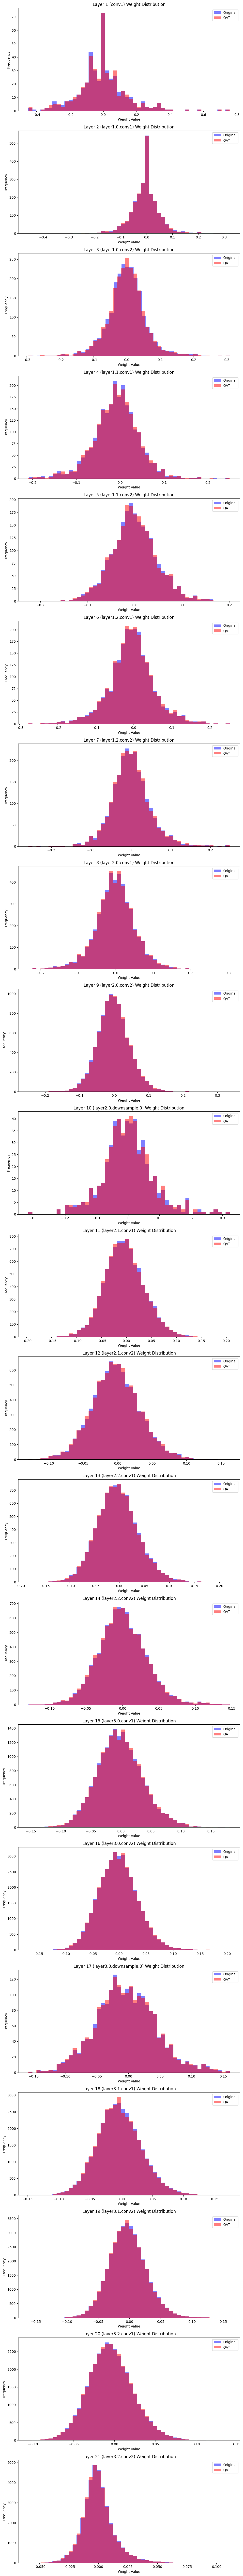

In [ ]:
plot_weight_distributions(layer_names, org_w, qat_w)

## Show activation distribution(box)

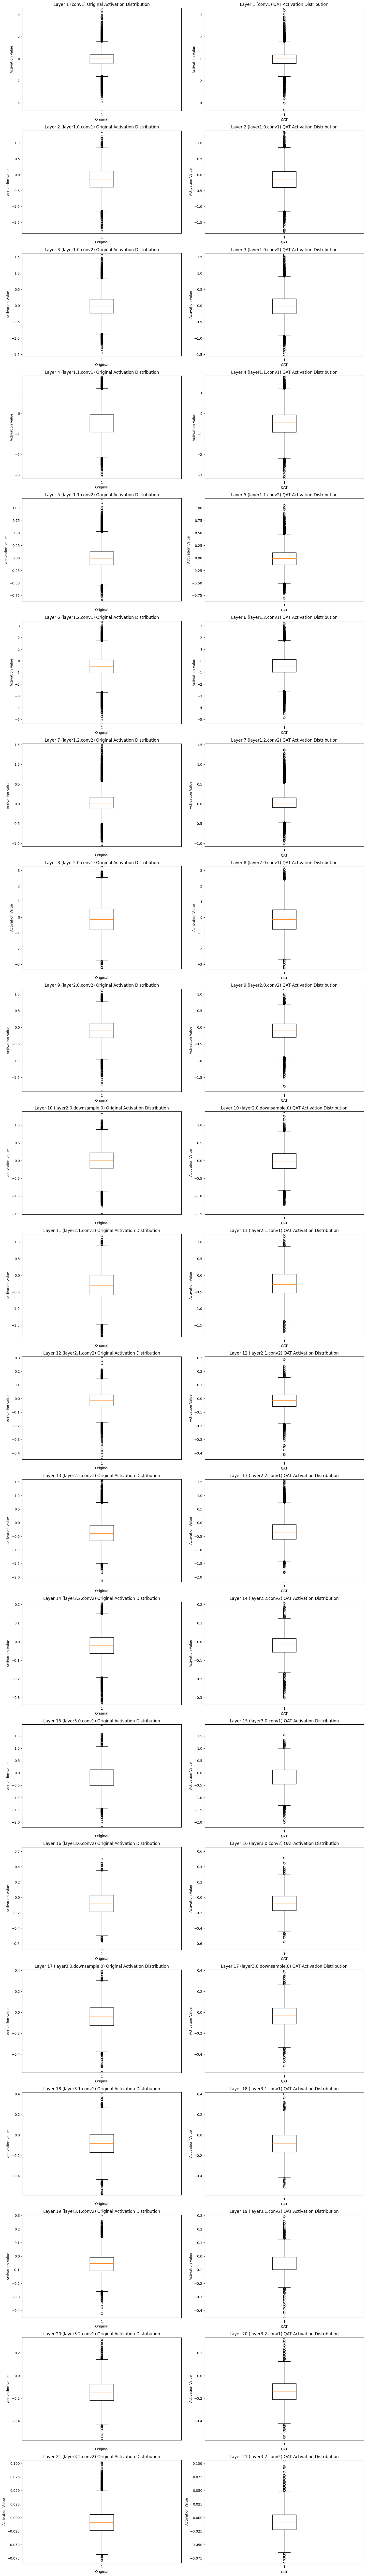

In [ ]:
plot_activation_distributions(layer_names, org_a, qat_a)

## Show activation distribution(histogram)

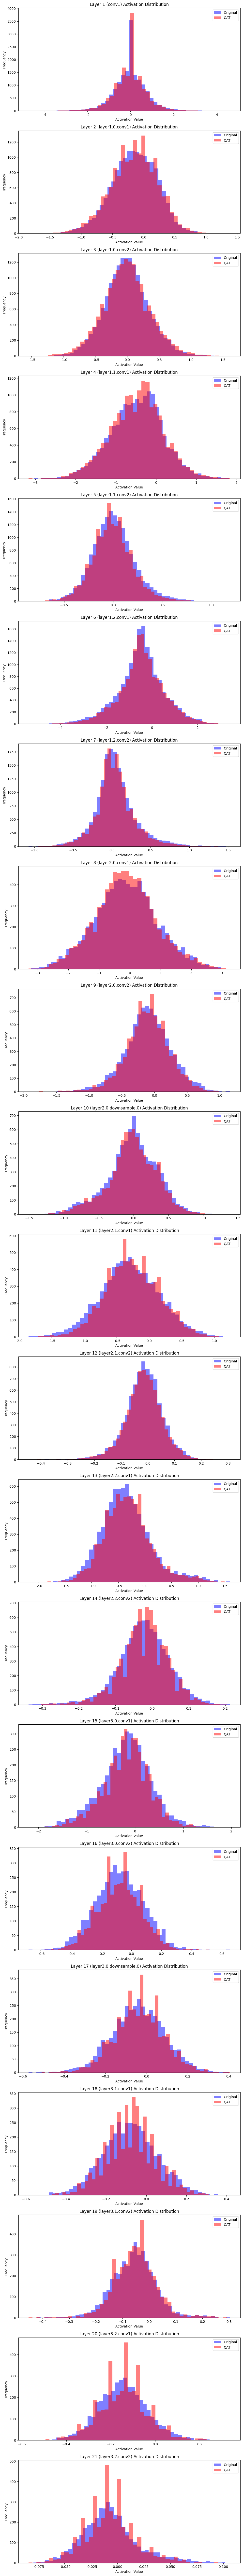

In [ ]:
plot_activation_histogram(layer_names, org_a, qat_a)

## Function: `measure_latency`

This function measures the latency of each layer in a given model. It is useful for performance analysis, particularly when comparing different model architectures or optimization techniques.


In [ ]:
def measure_latency(model, input_data, measurement_iterations=3):
    # Dictionary to store layer-wise latencies
    layer_latencies = {}
    layer_index = 0
    layer_indices = []

    # Hook functions to measure the start and end time of each layer
    def hook_fn_forward_start(module, input):
        module.start_time = time.time()

    def hook_fn_forward_end(module, input, output):
        nonlocal layer_index
        end_time = time.time()
        latency = end_time - module.start_time
        if layer_index in layer_latencies:
            layer_latencies[layer_index].append(latency)
        else:
            layer_latencies[layer_index] = [latency]
        layer_indices.append(layer_index)
        layer_index += 1

    # Register hooks for convolutional and linear layers
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear, torch.nn.quantized.Conv2d, torch.nn.quantized.Linear)):
            hooks.append(layer.register_forward_pre_hook(hook_fn_forward_start))
            hooks.append(layer.register_forward_hook(hook_fn_forward_end))

    # Measurement phase to collect latencies
    for _ in range(measurement_iterations):
        layer_index = 0
        with torch.no_grad():
            _ = model(input_data)

    # Remove hooks after measurement
    for hook in hooks:
        hook.remove()

    # Calculate average latency for each layer
    avg_layer_latencies = {index: sum(latencies) / len(latencies) for index, latencies in layer_latencies.items()}

    return avg_layer_latencies

In [ ]:
def plot_latency_comparison(original_latencies, quantized_latencies, layer_names, filename):
    # Prepare data for plotting
    layers = list(range(len(original_latencies)))
    original_times = [original_latencies[layer] for layer in layers]
    quantized_times = [quantized_latencies[layer] for layer in layers]

    # Plot latency comparison
    plt.figure(figsize=(10, 6))
    plt.bar(layers, original_times, width=0.4, label='Original', align='center')
    plt.bar([x + 0.4 for x in layers], quantized_times, width=0.4, label='Quantized', align='center')
    plt.xticks(layers, layer_names, rotation=90)  # Use layer names from original model for x-axis labels
    plt.xlabel('Layer')
    plt.ylabel('Latency (seconds)')
    plt.title('Layer-wise Latency Comparison')
    plt.legend()
    plt.tight_layout()  # Adjust layout to fit x-axis labels
    plt.savefig(filename)

In [ ]:
def plot_individual_latency(latencies, layer_names, model_name, filename):
    # Prepare data for plotting
    layers = list(range(len(latencies)))
    times = [latencies[layer] for layer in layers]

    # Plot individual model latencies
    plt.figure(figsize=(10, 6))
    plt.bar(layers, times, width=0.4, label=model_name, align='center')
    plt.xticks(layers, layer_names, rotation=90)  # Use layer names from original model for x-axis labels
    plt.xlabel('Layer')
    plt.ylabel('Latency (seconds)')
    plt.title(f'{model_name} Layer-wise Latency')
    plt.legend()
    plt.tight_layout()  # Adjust layout to fit x-axis labels
    plt.savefig(filename)

In [ ]:
dummy_input = torch.randn(64, 3, 224, 224)

# Measure latency for the quantized model
quantized_latencies = measure_latency(model, dummy_input)
total_quantized_latency = sum(quantized_latencies.values())

# Measure latency for the original model
original_model = cifar10_resnet20(pretrained=True).cpu().eval()
original_latencies = measure_latency(original_model, dummy_input)
total_original_latency = sum(original_latencies.values())

# Get layer names from the original model
layer_names = []
for name, layer in original_model.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        layer_names.append(name)

## Show latency of each layer

Total Original Model Latency: 9.106974 seconds
Total Quantized Model Latency: 5.081443 seconds


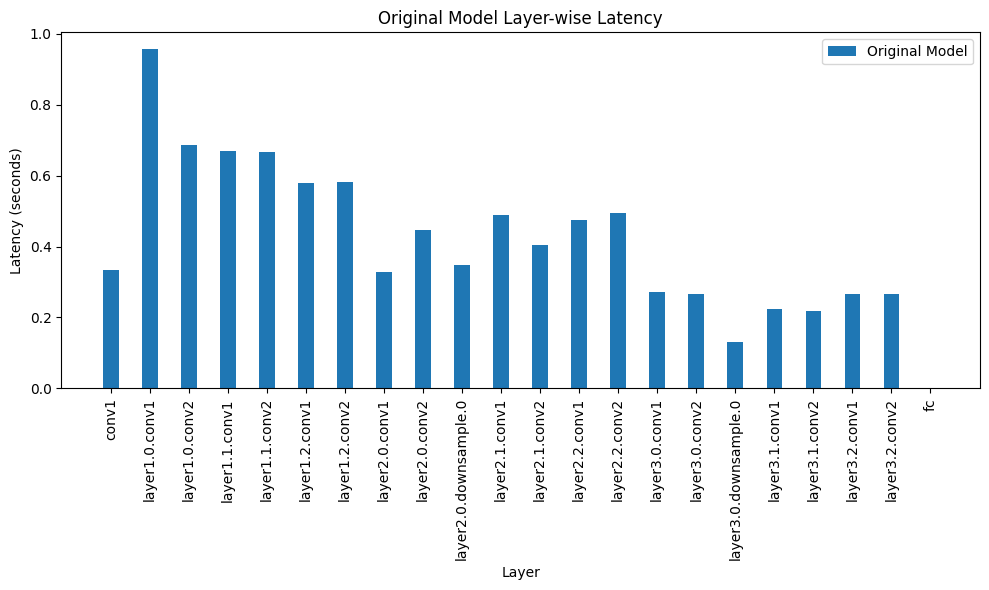

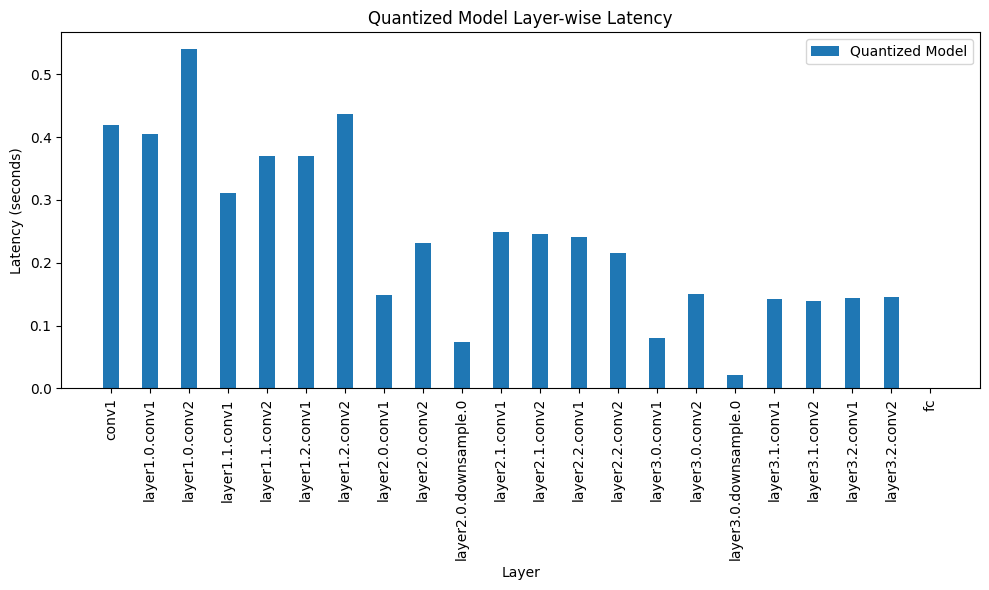

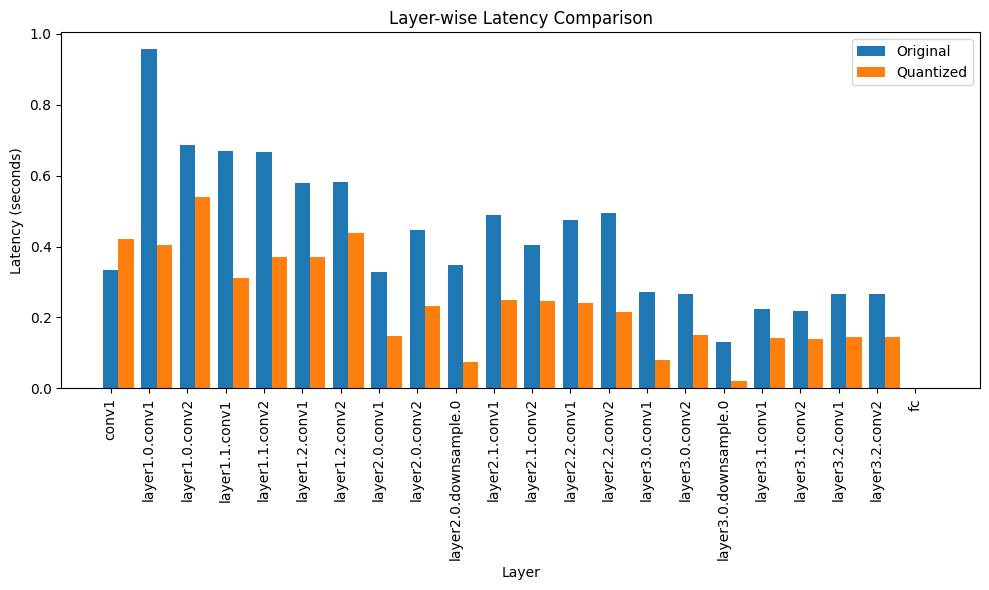

In [ ]:
# Plot and save individual latencies
plot_individual_latency(original_latencies, layer_names, 'Original Model', 'original_model_latency.png')
plot_individual_latency(quantized_latencies, layer_names, 'Quantized Model', 'quantized_model_latency.png')

# Plot and save the latency comparison
plot_latency_comparison(original_latencies, quantized_latencies, layer_names, 'latency_comparison.png')

# Print total latencies
print(f'Total Original Model Latency: {total_original_latency:.6f} seconds')
print(f'Total Quantized Model Latency: {total_quantized_latency:.6f} seconds')